In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
from scipy.optimize import minimize
import corner
import george

from approxposterior import approx

/Users/dflemin3/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


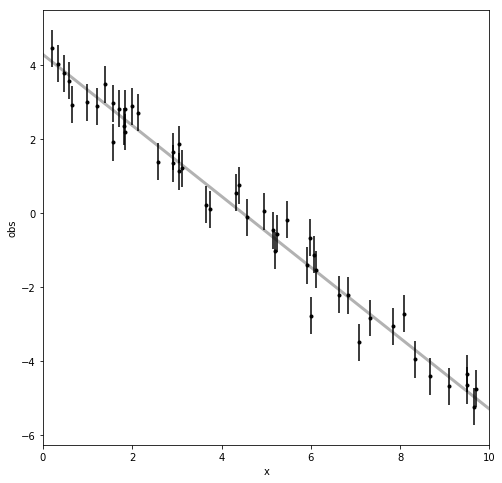

In [2]:
np.random.seed(42)

# Choose the "true" parameters.
mTrue = -0.9594
bTrue = 4.294

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
obserr = 0.5
obs = mTrue*x+bTrue
obs += obserr * np.random.randn(N)

fig, ax = plt.subplots(figsize=(8,8))

ax.errorbar(x, obs, yerr=obserr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
ax.plot(x0, mTrue*x0+bTrue, "k", alpha=0.3, lw=3)
ax.set_xlim(0, 10)
ax.set_xlabel("x")
ax.set_ylabel("obs");

In [3]:
def logLikelihood(theta, x, obs, obserr):
  
    theta = np.array(theta)
    m, b = theta
    
    model = m * x + b
    return -0.5*np.sum((obs-model)**2/obserr**2)

In [4]:
def logPrior(theta):
    
    theta = np.array(theta)
    m, b = theta
    
    if -5.0 < m < 0.5 and 0.0 < b < 10.0:
        return 0.0
    return -np.inf

In [5]:
def logProbability(theta, x, obs, obserr):
        
    lp = logPrior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + logLikelihood(theta, x, obs, obserr)

In [6]:
p0 = np.random.randn(32, 2)
nwalkers, ndim = p0.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, logProbability, args=(x, obs, obserr))
sampler.run_mcmc(p0, 5000);

/Users/dflemin3/anaconda3/lib/python3.6/site-packages/emcee-3.0rc2-py3.6.egg/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars


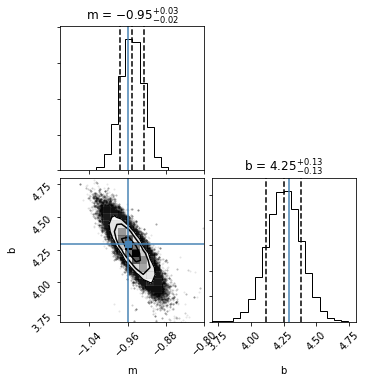

In [7]:
fig = corner.corner(sampler.flatchain,
                    quantiles=[0.16, 0.5, 0.84],
                    truths=[mTrue, bTrue],
                    labels=["m", "b"], range=([-1.1,-0.8],[3.7, 4.8]),
                    plot_contours=True, show_titles=True);

In [8]:
def sampleFunction(n):
    """
    docs

    Parameters
    ----------
    n : int
        Number of samples

    Returns
    -------
    sample : floats
        n x 3 array of floats samples from the prior
    """

    m = np.random.uniform(low=-5, high=0.5, size=(n))
    b = np.random.uniform(low=0, high=10, size=(n))
    
    return np.vstack([m,b]).squeeze().T
# end function

In [9]:
# Define algorithm parameters
m0 = 20                           # Initial size of training set
m = 10                            # Number of new points to find each iteration
nmax = 10                          # Maximum number of iterations
Dmax = 0.1                        # KL-Divergence convergence limit
kmax = 5                          # Number of iterations for Dmax convergence to kick in
nKLSamples = 10000                # Number of samples from posterior to use to calculate KL-Divergence
bounds = ((-5,0.5), (0.0,10.0))   # Prior bounds
algorithm = "BAPE"                # Use the Kandasamy et al. (2015) formalism

# emcee MCMC parameters
samplerKwargs = {"nwalkers" : 32}        # emcee.EnsembleSampler parameters
mcmcKwargs = {"iterations" : 5000} # emcee.EnsembleSampler.run_mcmc parameters

In [10]:
#Create a training set to condition the GP
args = (x, obs, obserr)

# Randomly sample initial conditions from the prior
theta = np.array(sampleFunction(m0))

# Evaluate forward model to compute log likelihood + lnprior for each theta
y = list()
for ii in range(len(theta)):
    y.append(logLikelihood(theta[ii], *args) + logPrior(theta[ii]))
y = np.array(y)

# Guess initial GP metric
initialMetric = np.mean(theta**2, axis=0)/theta.shape[-1]**3

# Create kernel 
kernel = george.kernels.ExpSquaredKernel(initialMetric, ndim=theta.shape[-1])

# Guess initial mean function
mean = np.mean(y)

# Create GP
gp = george.GP(kernel=kernel, fit_mean=True, mean=mean)
gp.compute(theta)

In [11]:
ap = approx.ApproxPosterior(theta=theta,
                            y=y,
                            gp=gp,
                            lnprior=logPrior,
                            lnlike=logLikelihood,
                            priorSample=sampleFunction,
                            algorithm=algorithm)

In [12]:
# Run!
ap.run(m=m, nmax=nmax, Dmax=Dmax, kmax=kmax, bounds=bounds,  estBurnin=True,
       nKLSamples=nKLSamples, mcmcKwargs=mcmcKwargs, cache=False,
       samplerKwargs=samplerKwargs, verbose=False, args=args)

/Users/dflemin3/approxposterior/approxposterior/utility.py:90: RuntimeWarning: invalid value encountered in log
  res = np.sum(np.log(p(x)/q(x)))/len(x)
/Users/dflemin3/approxposterior/approxposterior/utility.py:90: RuntimeWarning: invalid value encountered in log
  res = np.sum(np.log(p(x)/q(x)))/len(x)
/Users/dflemin3/approxposterior/approxposterior/utility.py:90: RuntimeWarning: invalid value encountered in log
  res = np.sum(np.log(p(x)/q(x)))/len(x)
/Users/dflemin3/approxposterior/approxposterior/utility.py:90: RuntimeWarning: invalid value encountered in log
  res = np.sum(np.log(p(x)/q(x)))/len(x)
/Users/dflemin3/approxposterior/approxposterior/utility.py:90: RuntimeWarning: invalid value encountered in log
  res = np.sum(np.log(p(x)/q(x)))/len(x)
/Users/dflemin3/approxposterior/approxposterior/utility.py:90: RuntimeWarning: invalid value encountered in log
  res = np.sum(np.log(p(x)/q(x)))/len(x)
/Users/dflemin3/approxposterior/approxposterior/utility.py:90: RuntimeWarning: inv

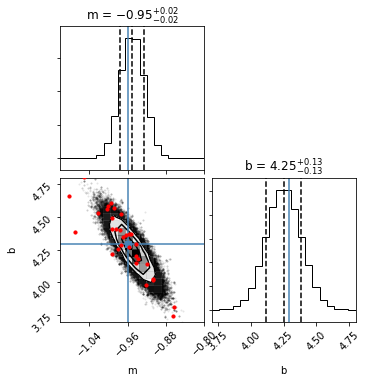

In [13]:
samples = ap.sampler.get_chain(discard=ap.iburns[-1], flat=True, thin=ap.ithins[-1])

fig = corner.corner(samples, quantiles=[0.16, 0.5, 0.84], truths=[mTrue, bTrue],
                    labels=["m", "b"], show_titles=True, scale_hist=True,
                    plot_contours=True, range=([-1.1,-0.8],[3.7, 4.8]));

# Plot where forward model was evaluated
fig.axes[2].scatter(ap.theta[:,0], ap.theta[:,1], s=10, color="red", zorder=20);